Load DATA 

In [195]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import numpy as np
from pgmpy.inference import VariableElimination  # Import VariableElimination from pgmpy.inference
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pgmpy.base import DAG


In [196]:
dataset_path = "Mental Health Dataset.csv"
df = pd.read_csv(dataset_path, sep=';')

In [197]:

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():  # Check if there are missing values in the column
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing values with mode

# Save the dataset with filled missing values to a CSV file
df.to_csv("filled_dataset.csv", index=False)


# PERFORM ONE HOT ENCODING

In [198]:
# Load the dataset (if not already loaded)
file_path = "filled_dataset.csv"  # Replace "filled_dataset.csv" with the path to your filled dataset
df_filled = pd.read_csv(file_path)

# Shuffle the dataset
df_filled = df_filled.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables using label encoding
categorical_cols = df_filled.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_filled[col] = label_encoder.fit_transform(df_filled[col])

# Display the encoded dataset
df_filled.to_csv("filled_dataset_encoding.csv", index=False)

# Now we get Test,Validation and Train data

In [199]:
# Define the desired sizes for the reduced datasets
train_data = df_filled[:60000]
val_data = df_filled[60000:80000]
test_data = df_filled[80000:100000]

train_data.to_csv("train_dataset.csv", index=False)
# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (60000, 17)
Validation data shape: (20000, 17)
Test data shape: (20000, 17)


# DEFINING THE MODEL

In [200]:
# Initialize BayesianModel
edges =[
    ('Gender', 'treatment'),
    ('Country', 'Occupation'),
    ('Country', 'self_employed'),
    ('Occupation', 'self_employed'),
    ('Occupation', 'treatment'),
    ('self_employed', 'treatment'),
    ('Mental_Health_History', 'Mood_Swings'),
    ('Mental_Health_History', 'Coping_Struggles'),
    ('Mood_Swings', 'treatment'),
    ('Coping_Struggles', 'treatment'),
    ('family_history', 'treatment'),
    ('Days_Indoors', 'treatment'),
    ('Growing_Stress', 'Coping_Struggles'),
    ('Mood_Swings', 'Coping_Struggles'),
    ('Changes_Habits', 'treatment'),
    ('Work_Interest', 'treatment'),
    ('Social_Weakness', 'treatment'),
    ('mental_health_interview', 'treatment'),
    ('care_options', 'treatment')
]



# TRAINING THE MODEL

In [201]:

# # Perform Hill climb search for the best model structure
# hc = HillClimbSearch(train_data)
# bic = BicScore(train_data)
# best_model_structure = hc.estimate(scoring_method=bic)

# # # Create the Bayesian model from the best structure

# # Fit the model using the training data
# best_model_structure.fit(train_data, estimator=MaximumLikelihoodEstimator)

# is_valid = model.check_model()
# # Check if CPDs are associated with all variables
# print(model.get_cpds())
# print(is_valid)

# Get the variables in the dataset
variables = train_data.columns.tolist()

# Create a Directed Acyclic Graph (DAG) with the same variables
start_dag = DAG()
start_dag.add_nodes_from(variables)

# Add edges from 'treatment' to all other variables except itself
for factor in variables:
    if factor != 'treatment':
        start_dag.add_edge(factor,'treatment' )

# Initialize HillClimbSearch object
hc = HillClimbSearch(train_data)

# Initialize BIC score
bic = BicScore(train_data)

# Perform Hill climb search for the best model structure
best_model_structure = hc.estimate(tabu_length=10, max_indegree=3, start_dag=start_dag, scoring_method=bic)

# Create the Bayesian model from the best structure
model = BayesianNetwork(best_model_structure.edges())

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

  0%|          | 0/1000000 [00:00<?, ?it/s]

# PREDICTING THE MODEL

In [202]:
# Perform inference for treatment outcome prediction
inference = VariableElimination(model)

# Function to predict treatment outcome for a given dataset
def predict_treatment_outcome(data):
    y_pred = []
    for _, row in data.iterrows():
        evidence = row.drop(['treatment', 'Timestamp']).to_dict()
        # Perform inference using VariableElimination
        query_result = inference.query(variables=['treatment'], evidence=evidence)
        # Extract the probability of the positive class (treatment)
        prob_treatment = query_result.values[1]
        # Compare the probability of treatment with a threshold (e.g., 0.5)
        y_pred.append(prob_treatment > 0.5)
    return y_pred

# Predict treatment outcome for the validation set
val_y_pred = predict_treatment_outcome(val_data)
val_y_true = val_data['treatment']

# Predict treatment outcome for the test set
test_y_pred = predict_treatment_outcome(test_data)
test_y_true = test_data['treatment']

# Calculating evaluation metrics

In [203]:
# Calculate evaluation metrics
accuracy = accuracy_score(val_y_true, val_y_pred)
precision = precision_score(val_y_true, val_y_pred)
recall = recall_score(val_y_true, val_y_pred)
f1 = f1_score(val_y_true, val_y_pred)
roc_auc = roc_auc_score(val_y_true, val_y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.7433
Precision: 0.7169425164620039
Recall: 0.8048951048951049
F1-score: 0.7583772590361446
ROC AUC: 0.7432383432383431


# BAYESIAN NETWORK DIAGRAM

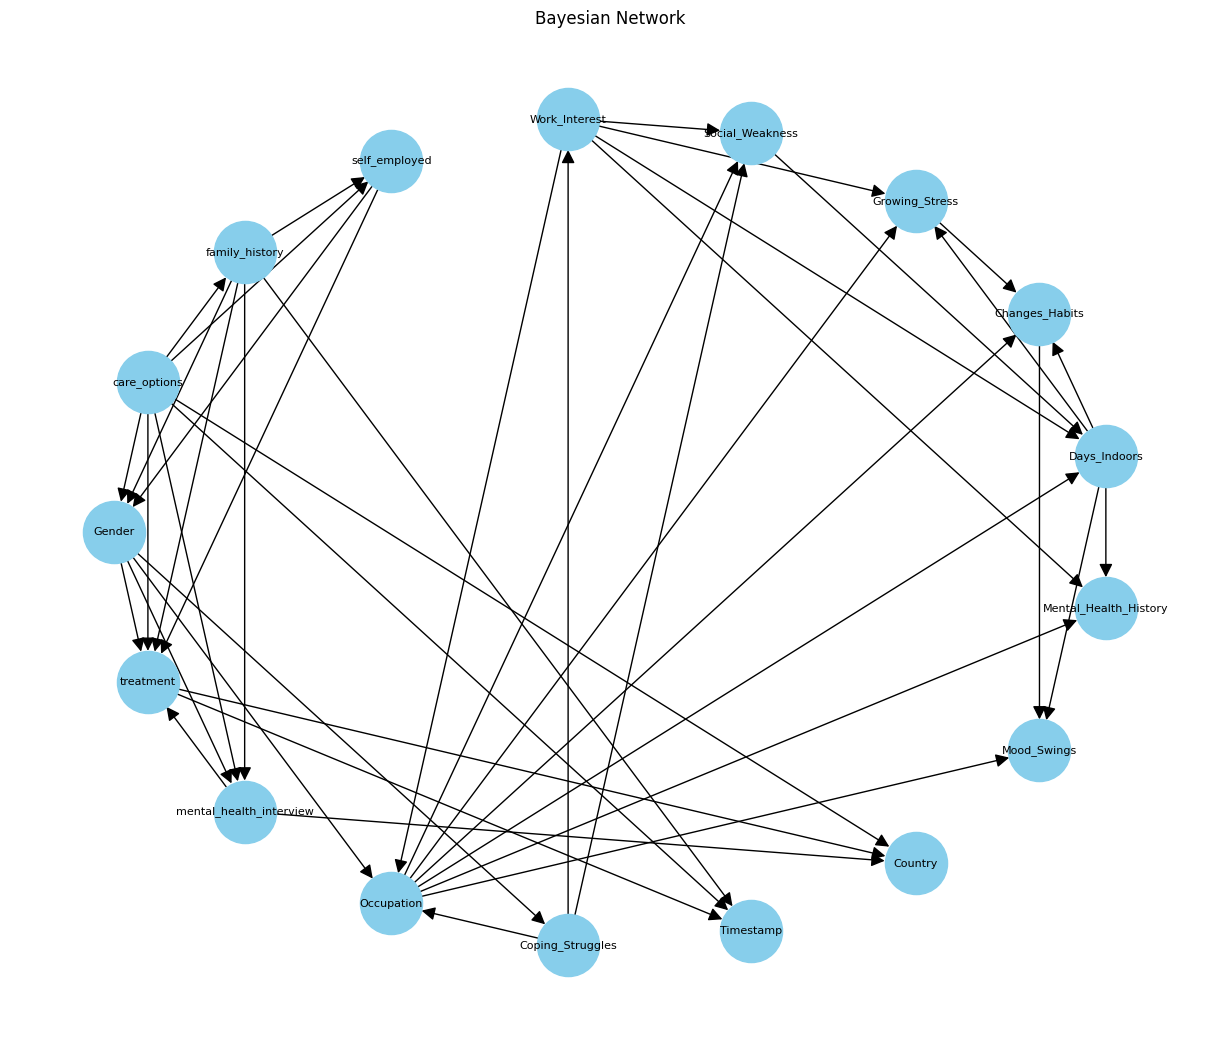

In [204]:
# Define the Bayesian network structure with V-structure and additional edges
# Visualize the Bayesian Network structure using networkx
G = nx.DiGraph(model.edges())
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=8, arrowsize=20)
plt.title("Bayesian Network")
plt.show()

# CONFUSTION MATRIX

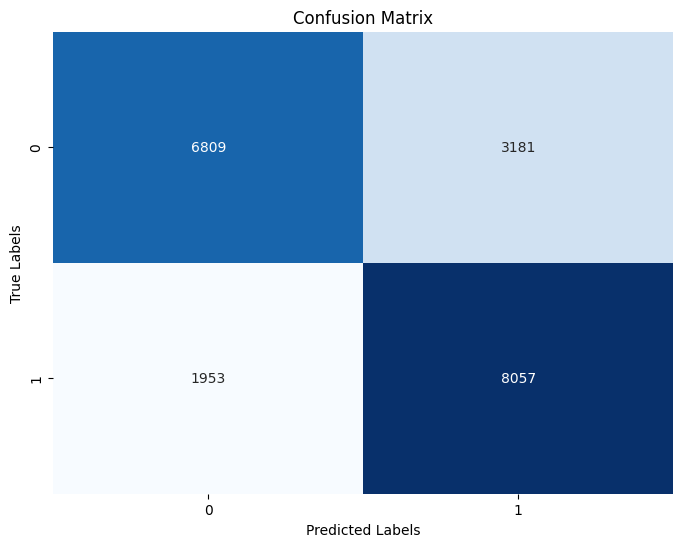

In [205]:
# Define true labels and predicted labels
true_labels = val_y_true  # Replace with your true labels
predicted_labels = val_y_pred  # Replace with your predicted labels

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CORRELATION MATRIX

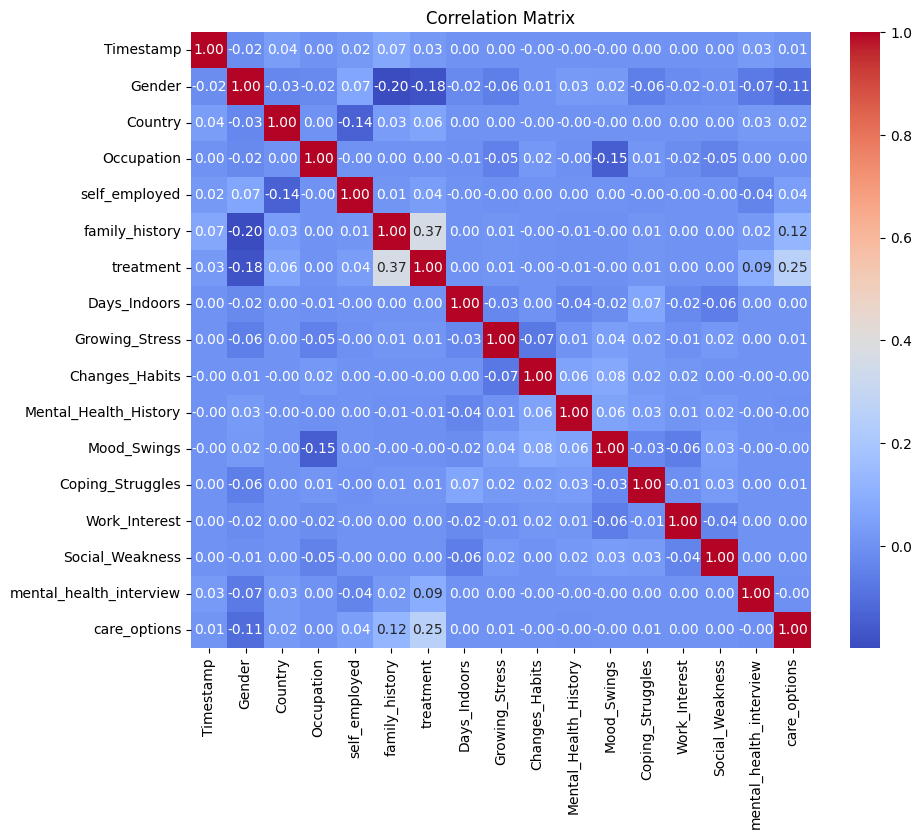

In [206]:


# Compute the correlation matrix
correlation_matrix = df_filled.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


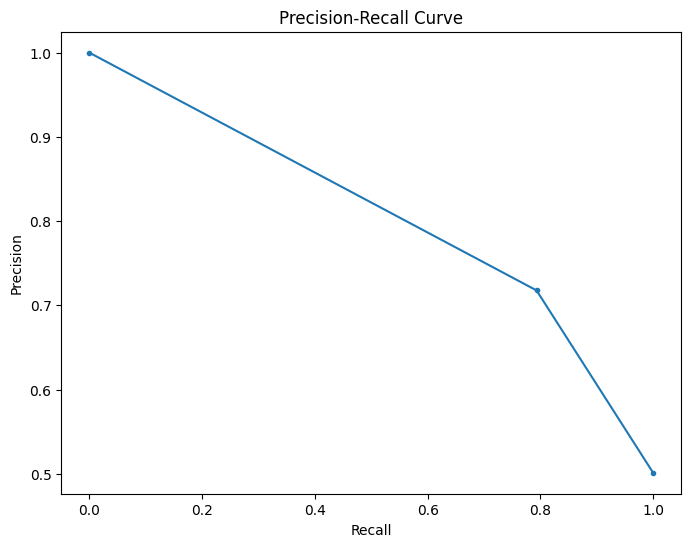

In [207]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_y_true, test_y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [208]:
# Evaluate the model on the test set
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(test_y_true, test_y_pred))
print("Precision:", precision_score(test_y_true, test_y_pred))
print("Recall:", recall_score(test_y_true, test_y_pred))
print("F1-Score:", f1_score(test_y_true, test_y_pred))


Test Set Performance:
Accuracy: 0.74
Precision: 0.7177543099557722
Recall: 0.793216957605985
F1-Score: 0.7536012130401819


In [209]:
# Evaluate the model on the validation set
print("Validation Set Performance:")
print("Accuracy:", accuracy_score(val_y_true, val_y_pred))
print("Precision:", precision_score(val_y_true, val_y_pred))
print("Recall:", recall_score(val_y_true, val_y_pred))
print("F1-Score:", f1_score(val_y_true, val_y_pred))

Validation Set Performance:
Accuracy: 0.7433
Precision: 0.7169425164620039
Recall: 0.8048951048951049
F1-Score: 0.7583772590361446
